# Reinforcement Learning Chess
Reinforcement Learning Chess is a series of notebooks where I implement Reinforcement Learning algorithms to develop a chess AI. I start of with simpler versions (environments) that can be tackled with simple methods and gradually expand on those concepts untill I have a full-flegded chess AI.

[Notebook 1: Policy Iteration](https://www.kaggle.com/arjanso/reinforcement-learning-chess-1-policy-iteration)  
[Notebook 2: Model-free learning](https://www.kaggle.com/arjanso/reinforcement-learning-chess-2-model-free-methods)  
[Notebook 3: Q-Learning](https://www.kaggle.com/arjanso/reinforcement-learning-chess-3-q-networks)  
[Notebook 4: Policy Gradients](https://www.kaggle.com/arjanso/reinforcement-learning-chess-4-policy-gradients)  

### Notebook 5: Monte Carlo tree search (MCTS)
The aim of this notebook is to build a chess AI that can plan moves and defeat a simple opponent in a regular game of chess. My approach can be summarized as follows:
- Instead of Q-learning (learning action values) I use "V-learning" (learning state-values).
    - An advantage is that the Neural Network can learn with fewer parameters since it doesn't need to learn a seperate value for each action. In my Q-learning and Policy Gradient notebook, the output vector has a size > 4000. Now the size is only 1.
- The V-network is updated using Temporal Difference (TD) Learning, like explained in Notebook 1. 
    - This option is the simplest to code.  Other options are TD-lambda and Monte Carlo Learning.
- The Architecture of the V-network is quite arbitrary and can probably be optimized. I used a combination of small and large convolutions, combined with convolutions that range a full file or rank (1-by-8 or 8-by-1).
- Moves are planned using Monte Carlo Tree Search. This involves simulating playouts. 
    - Monte Carlo Tree Search greatly improves performance on games like chess and go because it helps the agent to plan ahead.
- These playouts are truncated after N steps and bootstrapped. 
    - This reduces the variance of the simulation outcomes and gives performance gains, since the simulation doesn't require a full playout. 
- For this version, the opponent of the RL-agent is a myopic player, that always chooses the move that results in the most material on the board or a checkmate.

![chess_gif](https://images.chesscomfiles.com/uploads/game-gifs/90px/green/neo/0/cc/0/0/b3cwS2tzM05pcTlxYnEhVGRrVENrQ1hIQzQ_MzQ1N0Z3RjNWNTY4MHFrVlVtdVVnaGcyTTY_TUZnbzFUYXFXR2ZIWUlxR0tDSHlaUj84.gif)

**Import**

In [1]:
pip install chess


     |████████████████████████████████| 141 kB 427 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
!pip install --upgrade git+https://github.com/arjangroen/RLC.git@maintain-tree  # RLC is the Reinforcement Learning package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os
import inspect
import matplotlib.pyplot as plt

  Cloning https://github.com/arjangroen/RLC.git (to revision maintain-tree) to /tmp/pip-req-build-34d7l6q7
  Created wheel for RLC: filename=RLC-0.3-py3-none-any.whl size=22775 sha256=83b2ef467d9fcac3ddc692c5229bea2097b15d3a9cc9d7bab0bd8fd23d4066a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-nqloxg_8/wheels/54/44/47/0e3740271ea6403cbe7e0d58cb9de36329e0e9d86823a7e42d
Successfully built RLC
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from keras.models import load_model

In [4]:
import os
os.listdir('../input')

['b3cwS2tzM05pcTlxYnEhVGRrVENrQ1hIQzQ_MzQ1N0Z3RjNWNTY4MHFrVlVtdVVnaGcyTTY_TUZnbzFUYXFXR2ZIWUlxR0tDSHlaUj84-2.gif']

In [5]:
from RLC.real_chess import agent, environment, learn, tree
import chess
from chess.pgn import Game


opponent = agent.GreedyAgent()
env = environment.Board(opponent, FEN=None)
player = agent.Agent(lr=0.0005,network='big')
learner = learn.TD_search(env, player,gamma=0.9,search_time=0.9)
node = tree.Node(learner.env.board, gamma=learner.gamma)
player.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state (InputLayer)              [(None, 8, 8, 8)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 4)      36          state[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 8)      264         state[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 3, 12)     876         state[0][0]                      
_______________________________________________________________________________________

### Launching the network

In [6]:
n_iters = 10000  # maximum number of iterations
timelimit = 3600 # maximum time for learning
network_replacement_interval = 10  # For the stability of the nearal network updates, the network is not continuously replaced

iter 0
game ended with result 1.0 and material balance 2.0 in 9 halfmoves
game ended with result 0.0 and material balance -18.0 in 81 halfmoves
game ended with result -1.0 and material balance -21.0 in 60 halfmoves
game ended with result 0.0 and material balance -15.0 in 81 halfmoves
game ended with result 0.0 and material balance -18.0 in 81 halfmoves


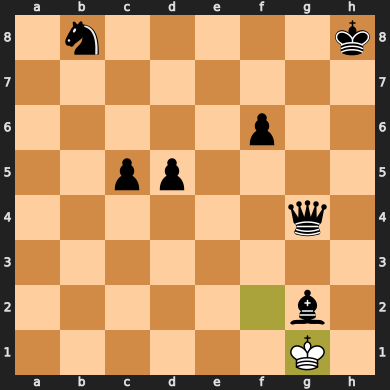

In [7]:
learner.learn(iters=n_iters,timelimit_seconds=timelimit,c=network_replacement_interval) 

### Learning performance 

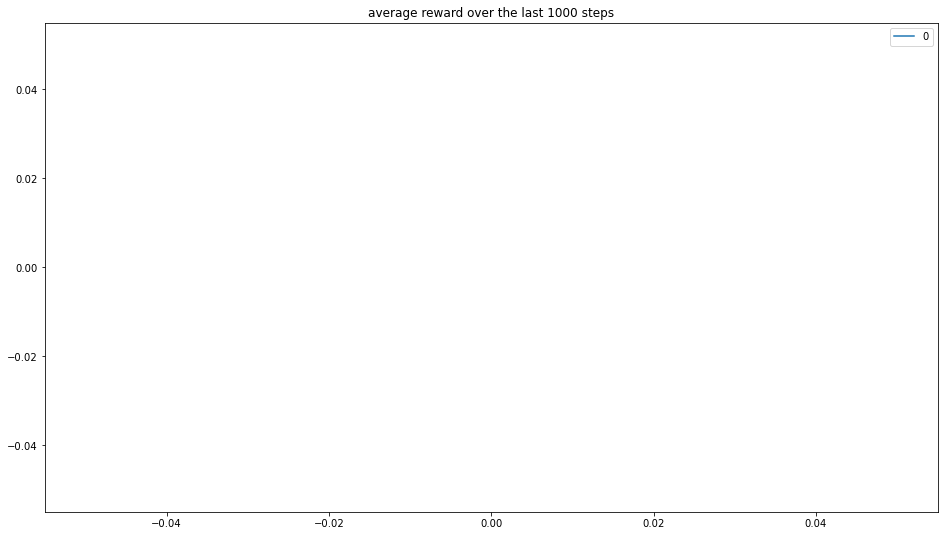

In [8]:
reward_smooth = pd.DataFrame(learner.reward_trace)
reward_smooth.rolling(window=1000,min_periods=1000).mean().plot(figsize=(16,9),title='average reward over the last 1000 steps')
plt.show()

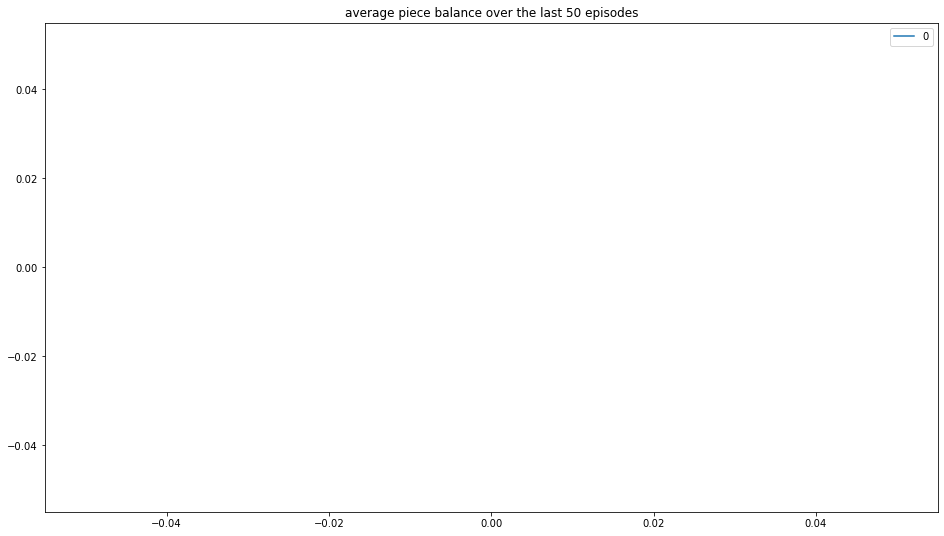

In [9]:
reward_smooth = pd.DataFrame(learner.piece_balance_trace)
reward_smooth.rolling(window=50,min_periods=50).mean().plot(figsize=(16,9),title='average piece balance over the last 50 episodes')
plt.show()

### Final performance with large searchtime and more greedy behavior

In [10]:
learner.env.reset()
learner.search_time = 60
learner.temperature = 1/3

game ended with result 0.0 and material balance -7.0 in 129 halfmoves


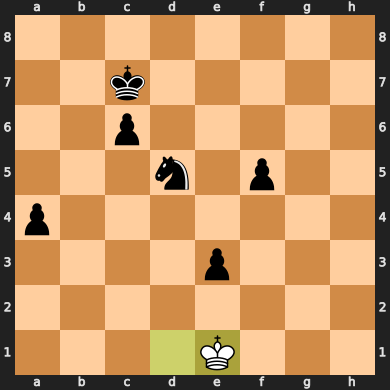

In [11]:
learner.play_game(n_iters,maxiter=128)

In [12]:
pgn = Game.from_board(learner.env.board)
with open("rlc_pgn","w") as log:
    log.write(str(pgn))

In [13]:
learner.agent.model.save('RLC_model.h5')

# References
**Reinforcement Learning: An Introduction**  
Richard S. Sutton and Andrew G. Barto  
1st Edition  
MIT Press, march 1998  
  
**RL Course by David Silver: Lecture playlist**  
https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ